In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

## Anomaly detection in time series using z score.

In [2]:
# !ls

### Load and resample the dataset from half hours into hours:

In [3]:
df = pd.read_csv('nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', drop=True, inplace=True)
df = df.resample("H").sum()
df['Date'] = df.index
print('Size of df:',df.shape[0])
df.head(3)

Size of df: 5160


,value,Date
timestamp,,
2014-07-01 00:00:00,18971,2014-07-01 00:00:00
2014-07-01 01:00:00,10866,2014-07-01 01:00:00
2014-07-01 02:00:00,6693,2014-07-01 02:00:00


### Visualise the data with moving averages (48 periods and 200 periods)

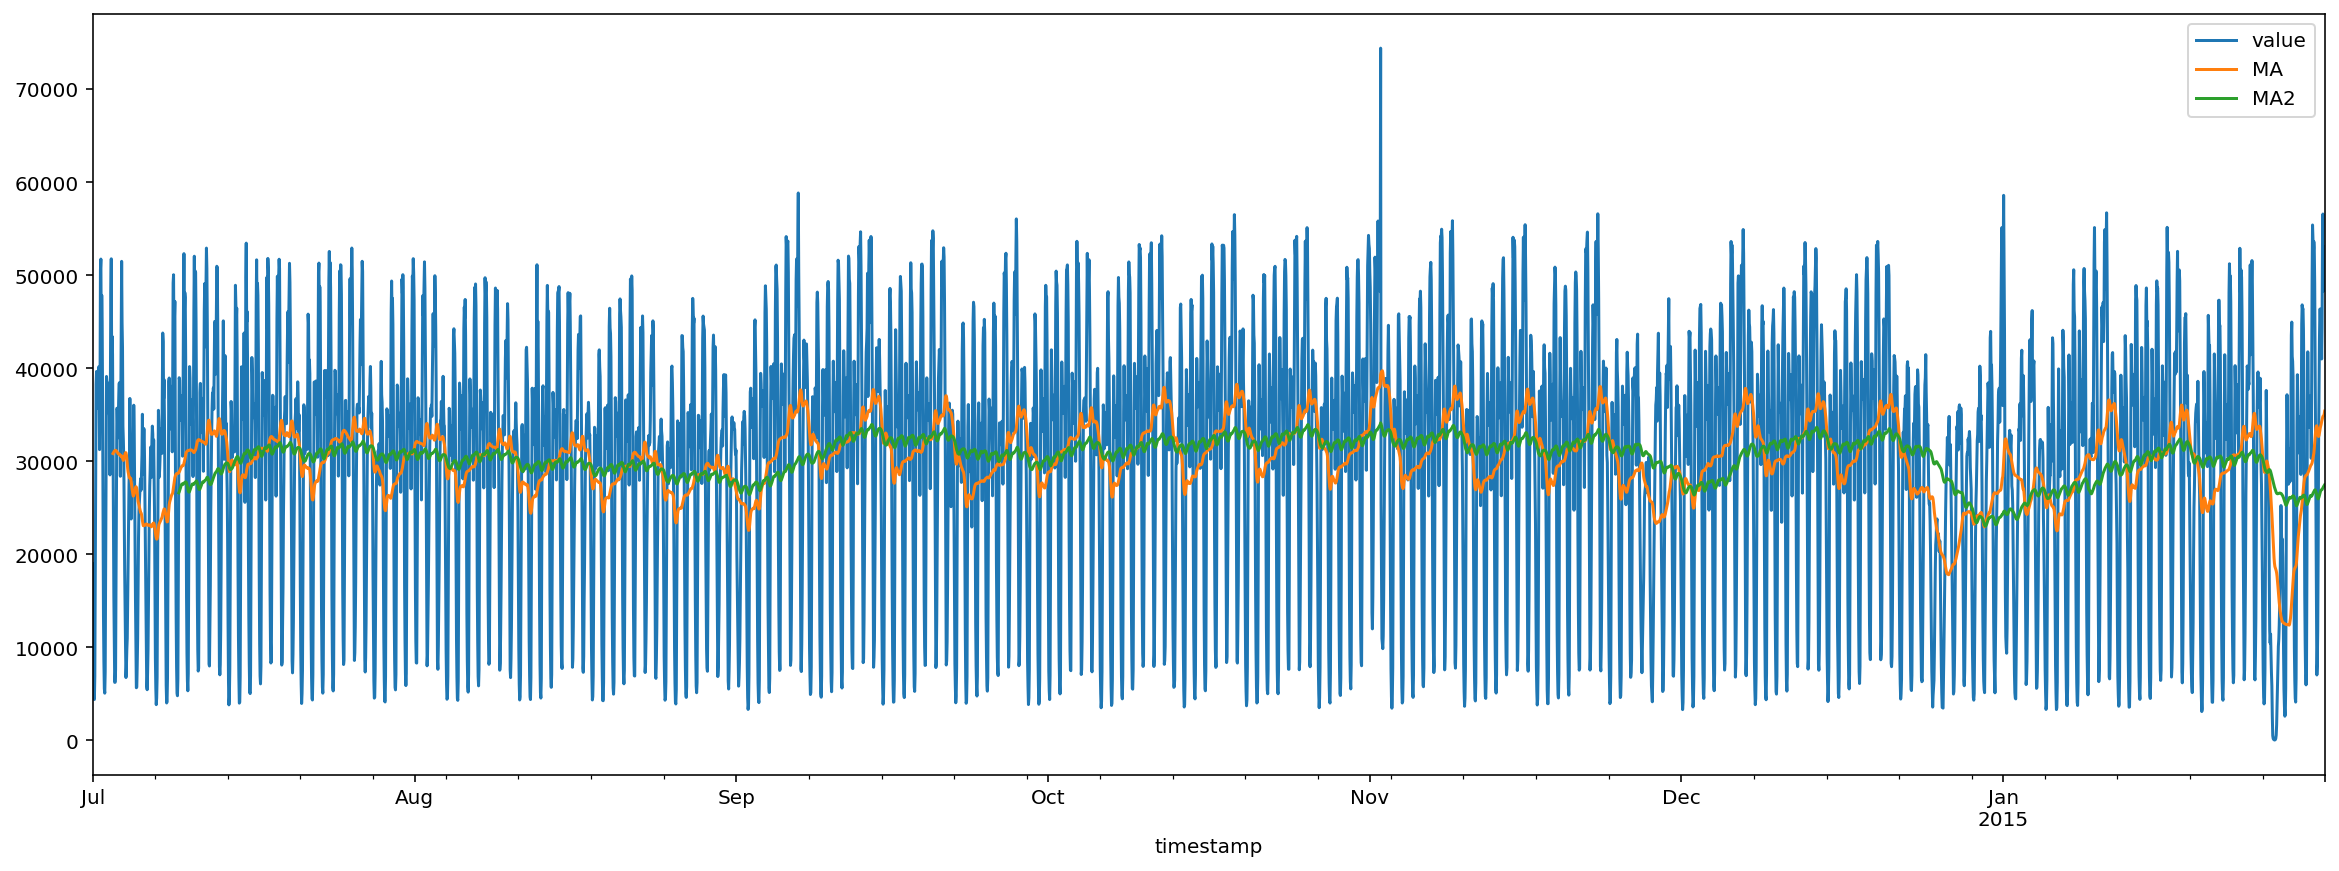

In [4]:
df['MA'] = df['value'].rolling(48).mean() 
df['MA2'] = df['value'].rolling(200).mean()
# df['std'] = df['value'].rolling(48).std()
df[['value','MA','MA2']].plot(figsize=(20,7));

### Anomaly detection with Z score:

Z-score is the number of standard deviations a given data point lies from the mean. For data points that are below the mean, the Z-score is negative. 

In most large datasets, 99% of values have a Z-score between -3 and 3, meaning they lie within three standard deviations above and below the mean.

The rule of thumb is to use 2, 2.5, 3 or 3.5 as threshold.

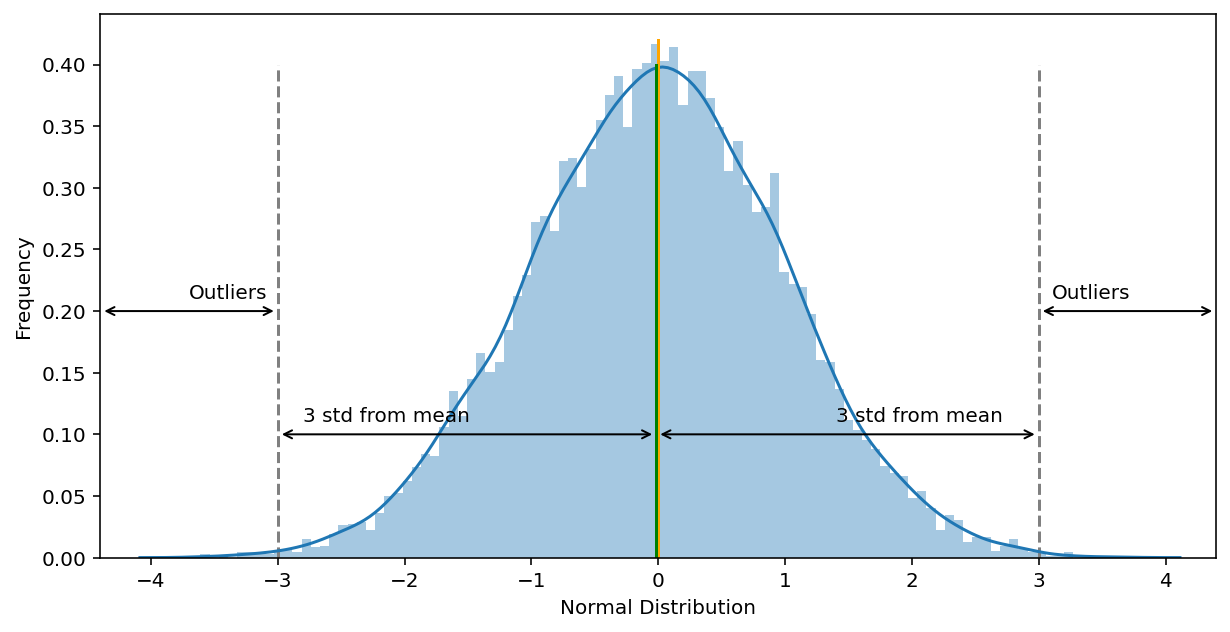

In [5]:
from scipy.stats import norm

# generate random numbers from N(0,1)
data_normal = norm.rvs(size=10000,loc=0,scale=1)

fig,ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(data_normal,bins=100,kde=True,hist_kws={"linewidth": 15,'alpha':0.4})

# print('Mean:',np.mean(data_normal),'Median:',np.median(data_normal),'Std:',np.std(data_normal))

ax.plot([np.median(data_normal),np.median(data_normal)],[0,0.42],color='orange')
ax.plot([np.mean(data_normal),np.mean(data_normal)],[0,0.4],color='green')

for i in [-3,3]:
    # x, ymin, ymax,
    ax.vlines(i, 0, 0.4, colors='grey', linestyles='dashed', label='')
    # arrow 3 std
    plt.annotate(s='', xy=(np.mean(data_normal),0.1), xytext=(i,0.1),arrowprops=dict(arrowstyle='<->'))
    # arrow outliers
    plt.annotate(s='', xy=(i,0.2), xytext=(i*1.4667,0.2),arrowprops=dict(arrowstyle='<->'))

# text annot'
plt.annotate(s='3 std from mean', xy=(np.mean(data_normal),0.11), xytext=(-2.8,0.11))
plt.annotate(s='3 std from mean', xy=(np.mean(data_normal),0.11), xytext=(1.4,0.11))

plt.annotate(s='Outliers', xy=(3.5,0.21), xytext=(3.1,0.21))
plt.annotate(s='Outliers', xy=(-3,0.21), xytext=(-3.7,0.21))

ax.set_xlim(left=-4.4,right=4.4)
ax.set(xlabel='Normal Distribution', ylabel='Frequency');

### Test before feature engineering:

In [6]:
### Detect and exclude outliers
def detect_outlier(x):
    outliers=[]
    threshold_, mean_ ,std_ = 2, np.mean(x), np.std(x)
    
    for i in x:
        z_score= (i - mean_)/std_
        if np.abs(z_score) > threshold_:
            outliers.append(i)
        else:
            outliers.append(None)
    return outliers

df['outliers'] = detect_outlier(df['value'])

### It will only shows extremes AND threshold is only set to 2, not great results:

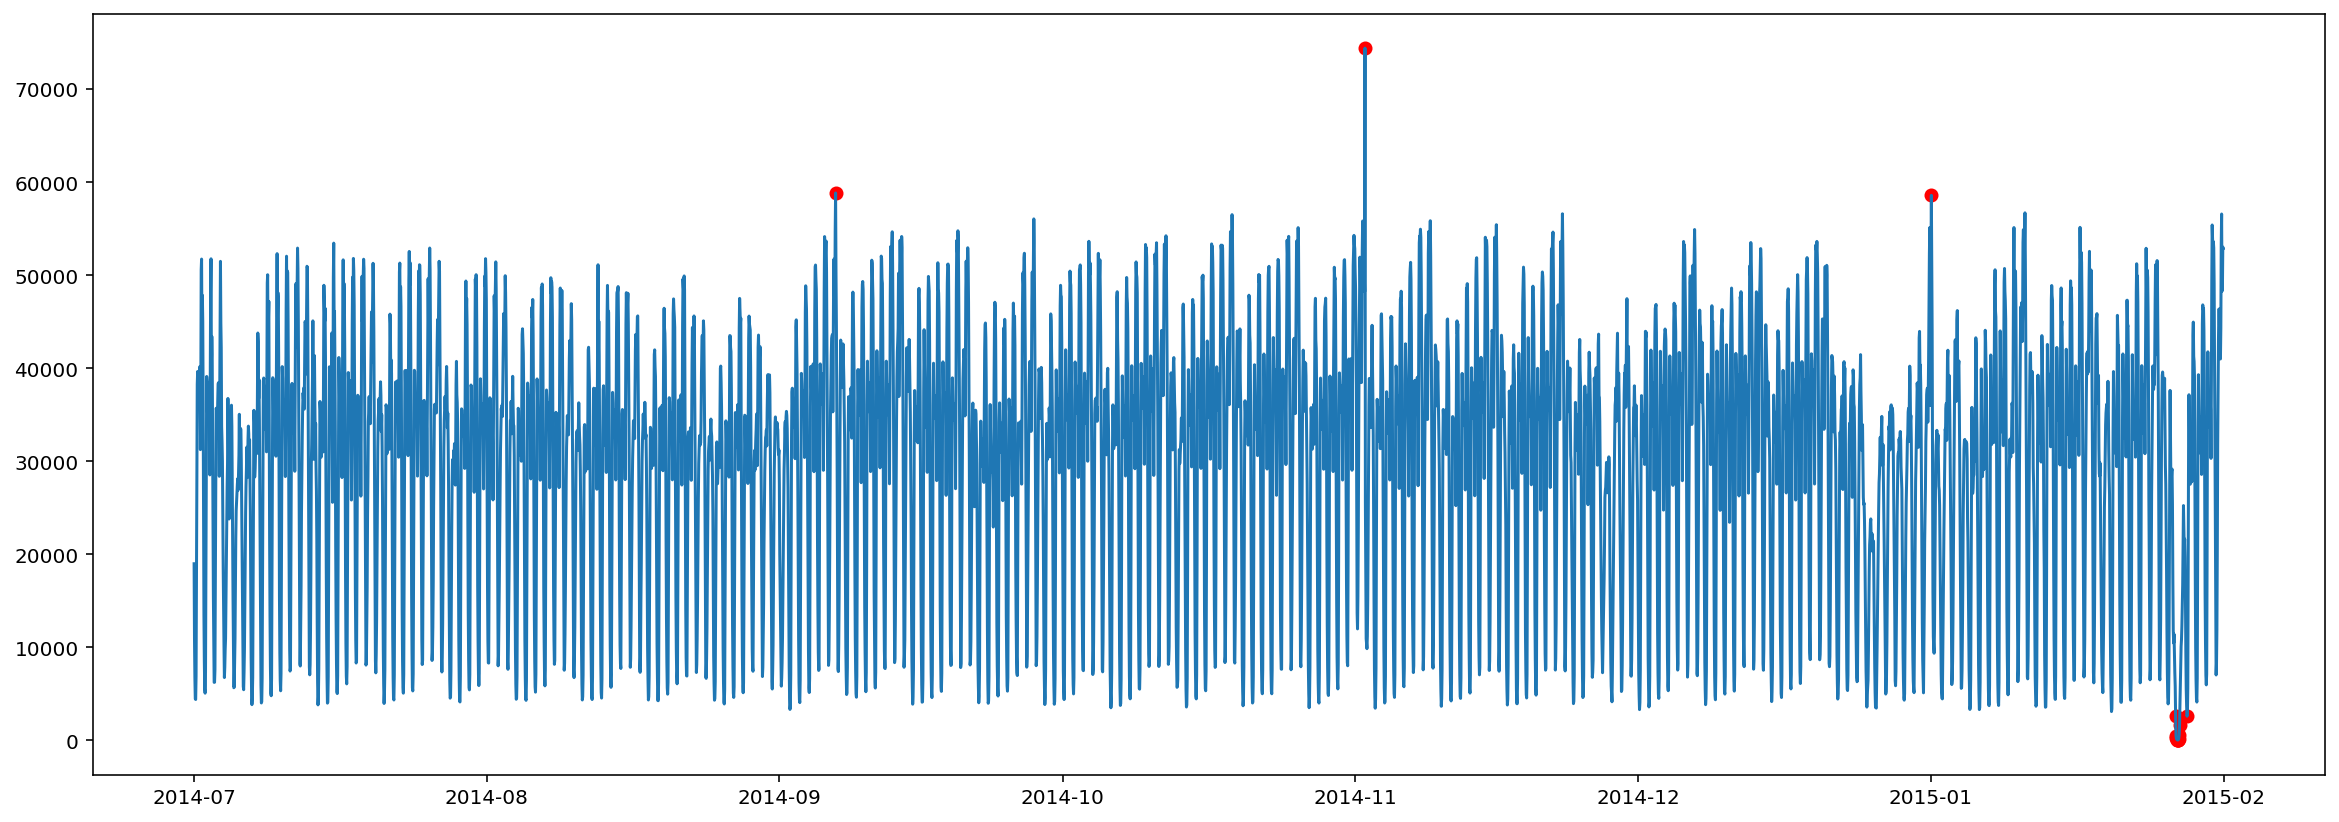

In [7]:
fig, ax = plt.subplots(figsize=(20,7))
plt.plot(df.index,df['value'])#,color='blue')
plt.scatter(df.index,df['outliers'],color='red');

## Breakdown the timestamp columns into features to refine the above operation:

### Drop moving-average columns:

In [8]:
df.drop(['MA', 'MA2','outliers'], axis=1, inplace=True)

### Creature features from date:

In [9]:
df['day'] = [i.day for i in df.index]  
df['day_name'] = [i.day_name() for i in df.index]  
df['day_of_year'] = [i.dayofyear for i in df.index]  
df['week_of_year'] = [i.weekofyear for i in df.index]  
df['hour'] = [i.hour for i in df.index]  
df['weekday'] = [i.isoweekday() for i in df.index]
df['weekend'] = [1 if x <= 5 else 2 for x in df['weekday']]
df.head(3)

,value,Date,day,day_name,day_of_year,week_of_year,hour,weekday,weekend
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,2014-07-01 00:00:00,1,Tuesday,182,27,0,2,1
2014-07-01 01:00:00,10866,2014-07-01 01:00:00,1,Tuesday,182,27,1,2,1
2014-07-01 02:00:00,6693,2014-07-01 02:00:00,1,Tuesday,182,27,2,2,1


In [10]:
for i in df.columns[2:]:
    print('{:15}  unique count: {:3} {}'.format(i,len(df[i].unique()),sorted(df[i].unique())[:30]))

day              unique count:  31 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
day_name         unique count:   7 ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
day_of_year      unique count: 215 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
week_of_year     unique count:  31 [1, 2, 3, 4, 5, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
hour             unique count:  24 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
weekday          unique count:   7 [1, 2, 3, 4, 5, 6, 7]
weekend          unique count:   2 [1, 2]


In [11]:
df.columns

Index(['value', 'Date', 'day', 'day_name', 'day_of_year', 'week_of_year',
       'hour', 'weekday', 'weekend'],
      dtype='object')

### Now that we have created features, we will apply our outliers function on each new columns, create a column of outliers and merge them into one:

In [12]:
%%time

try:
    df.drop('outliers')
except Exception:
    pass

### Detect outliers based on z_score and threshold ###
def detect_outlier(x):
    outliers=[]
    threshold_, mean_, std_ = 3, np.mean(x), np.std(x)
    
    for k in x:
        z_score= (k - mean_)/std_
        if np.abs(z_score) > threshold_:
            outliers.append(k)
        else:
            outliers.append(None)
    return outliers
######################################################

## create an empty column for the fillna operation below.
df['outliers'] = None

## loop through features from the timestamp to filter for each value within:
for col in ['day', 'day_name', 'day_of_year', 'week_of_year','hour', 'weekday','weekend']:
    for att in df[col].unique():
        df1 = df[df[col] == att]
        
        ## identify the outliers:
        df1['outliers_'+str(col)+'_'+str(att)] = detect_outlier(df1['value'])
        
        ## get the common columns of both dfs (df and df1) used to merge on below:
        intersection = list(set(df.columns).intersection(df1.columns))
        
        ## merge
        df = df.merge(df1,how='left',left_on=intersection,right_on=intersection)
        
        ## combine all the 'outliers_...' columns into one:
        listy = [x for x in df.columns if 'outliers_' in x]
        for i in listy:
            df['outliers'] = df['outliers'].fillna(df[i])
            df.drop(listy, axis=1, inplace=True)  

df.head(3)

CPU times: user 2.36 s, sys: 9.68 ms, total: 2.37 s
Wall time: 2.37 s


,value,Date,day,day_name,day_of_year,week_of_year,hour,weekday,weekend,outliers
0,18971,2014-07-01 00:00:00,1,Tuesday,182,27,0,2,1,NaN
1,10866,2014-07-01 01:00:00,1,Tuesday,182,27,1,2,1,NaN
2,6693,2014-07-01 02:00:00,1,Tuesday,182,27,2,2,1,NaN


### And visualise the results once again:

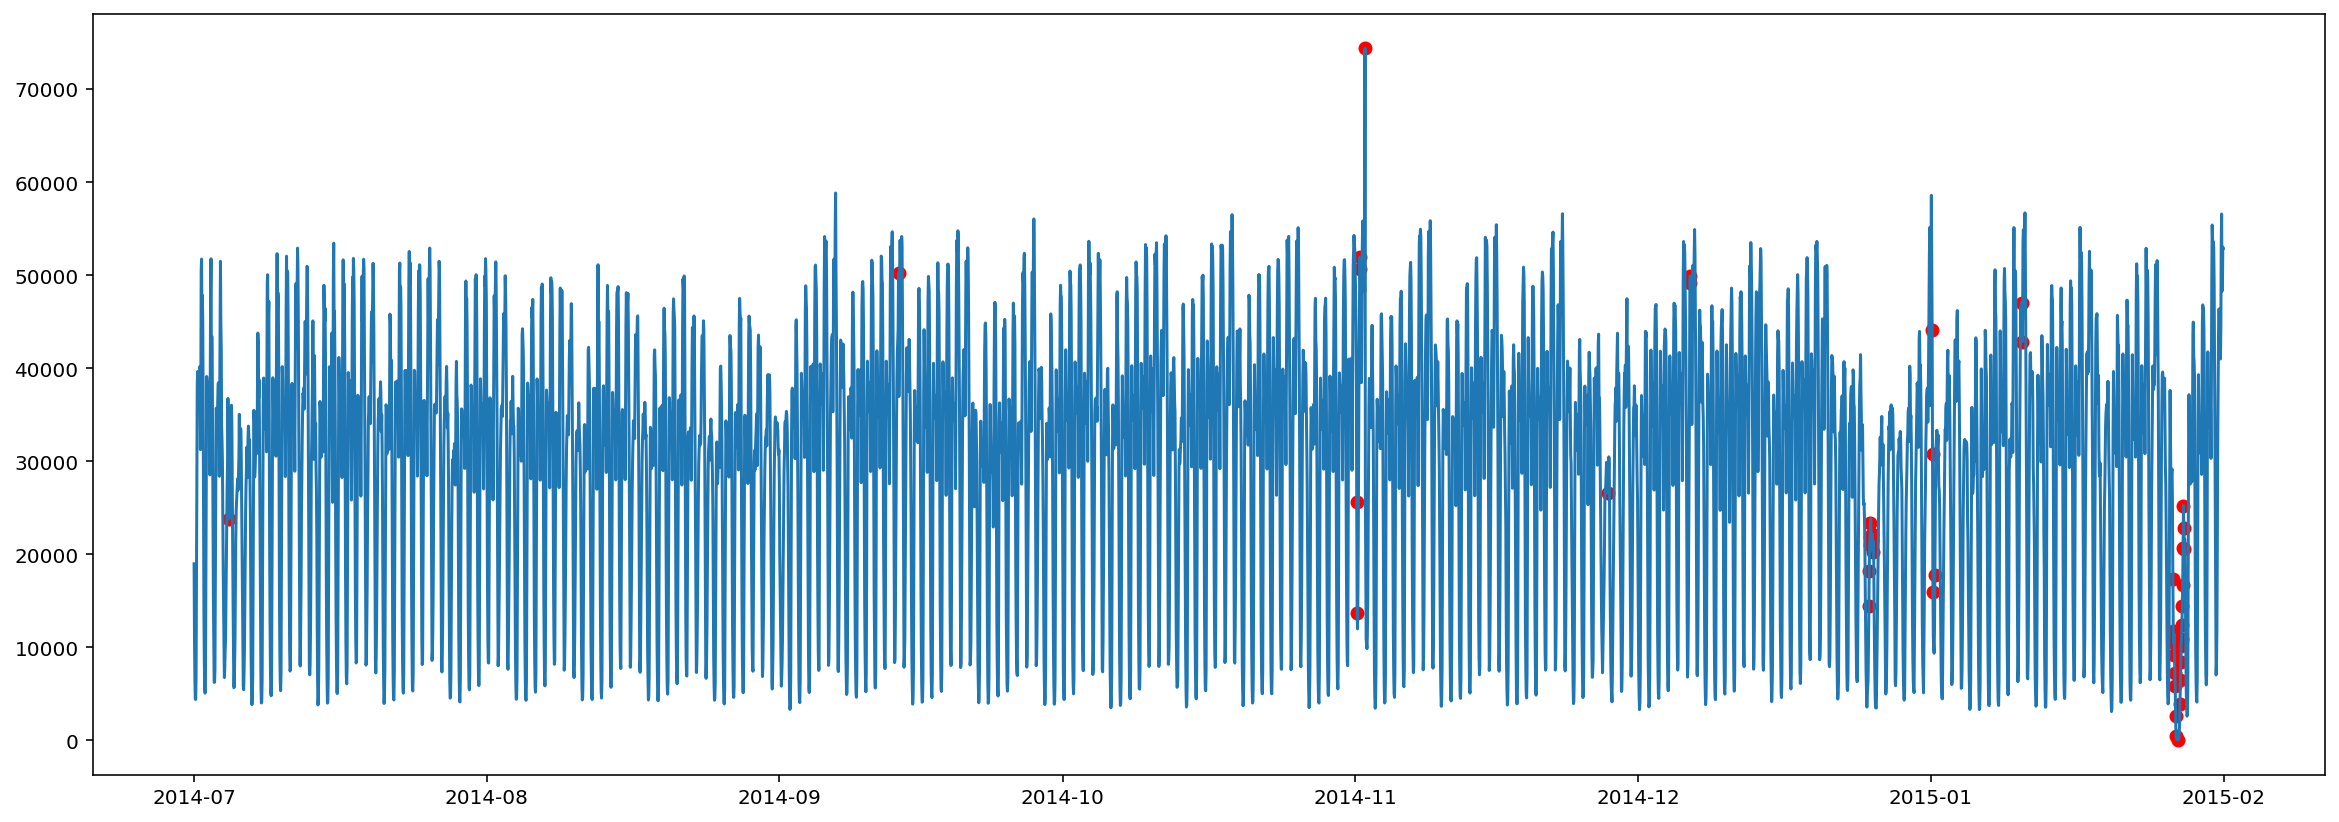

In [13]:
fig, ax = plt.subplots(figsize=(20,7))
plt.plot(df['Date'],df['value'])
plt.scatter(df['Date'],df['outliers'],color='red');

### Drilldown into end of 2014 - early 2015, what do you see?

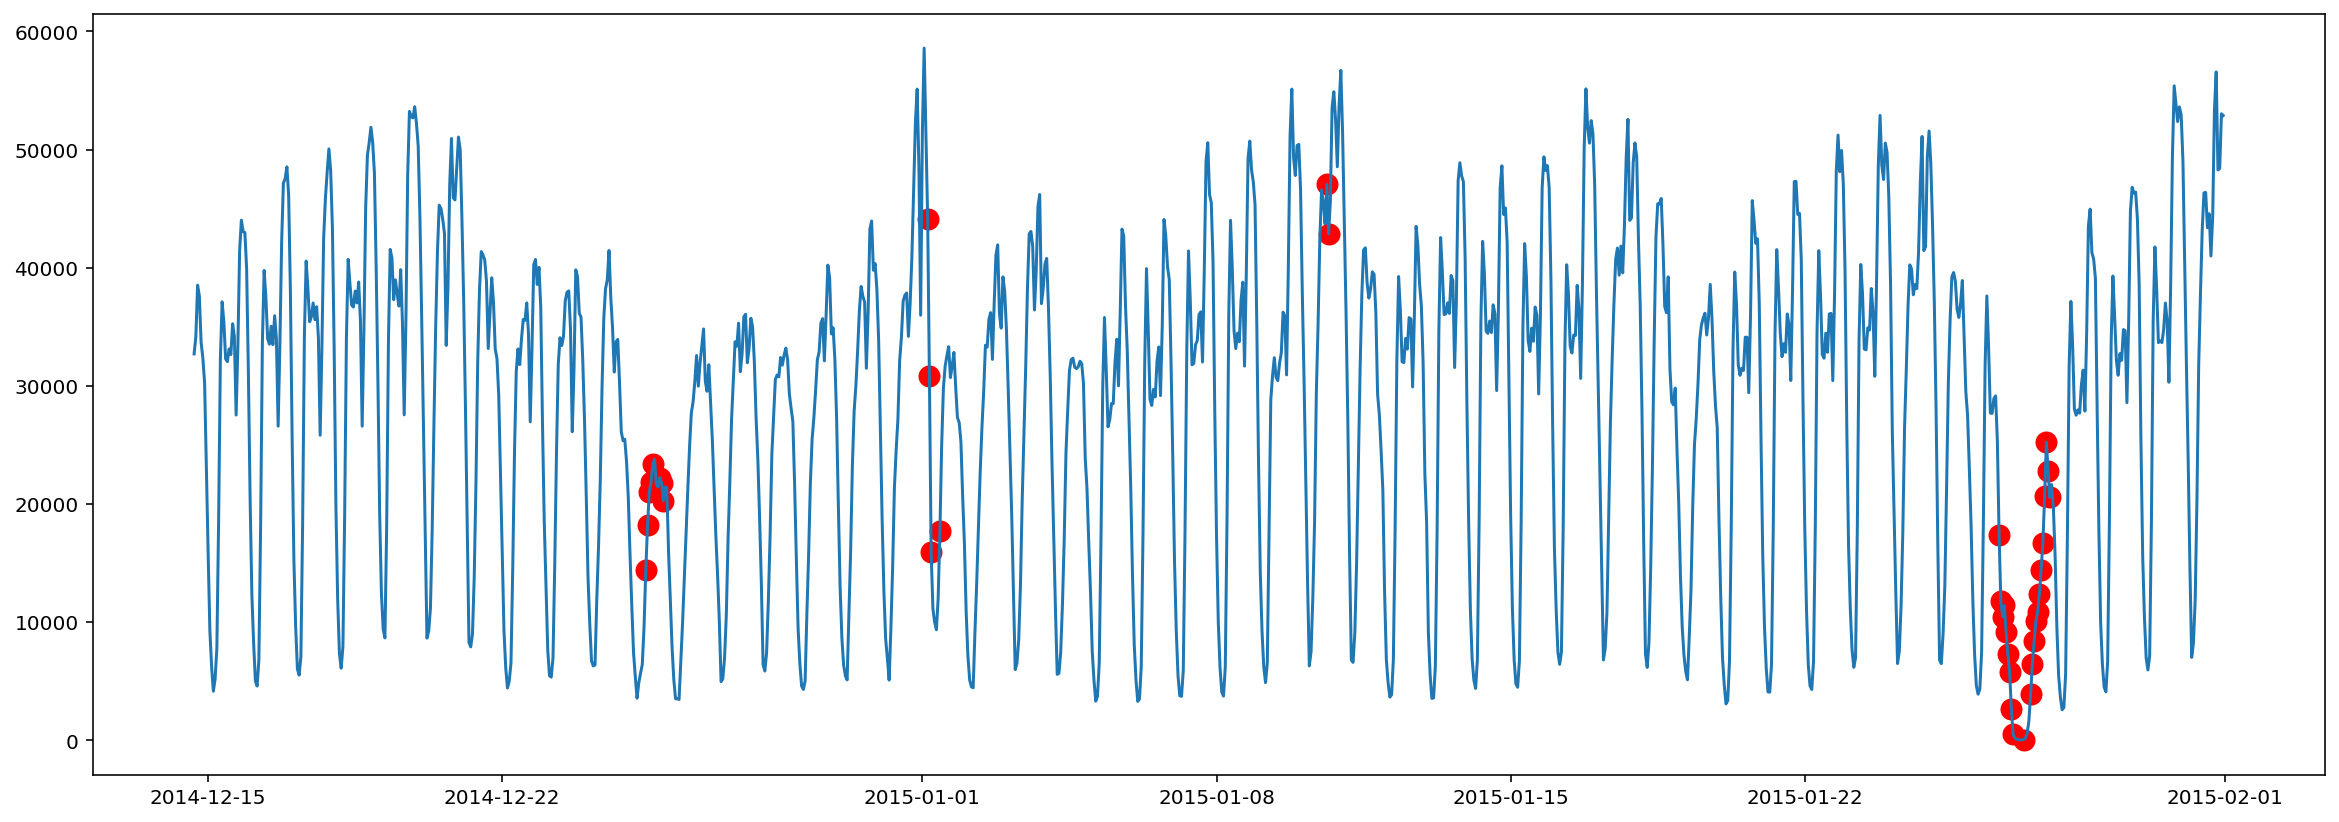

In [14]:
fig, ax = plt.subplots(figsize=(20,7))
plt.plot(df['Date'][4000:],df['value'][4000:])
plt.scatter(df['Date'][4000:],df['outliers'][4000:],color='red',s=100);

### Christmas? new year's eve? what else?

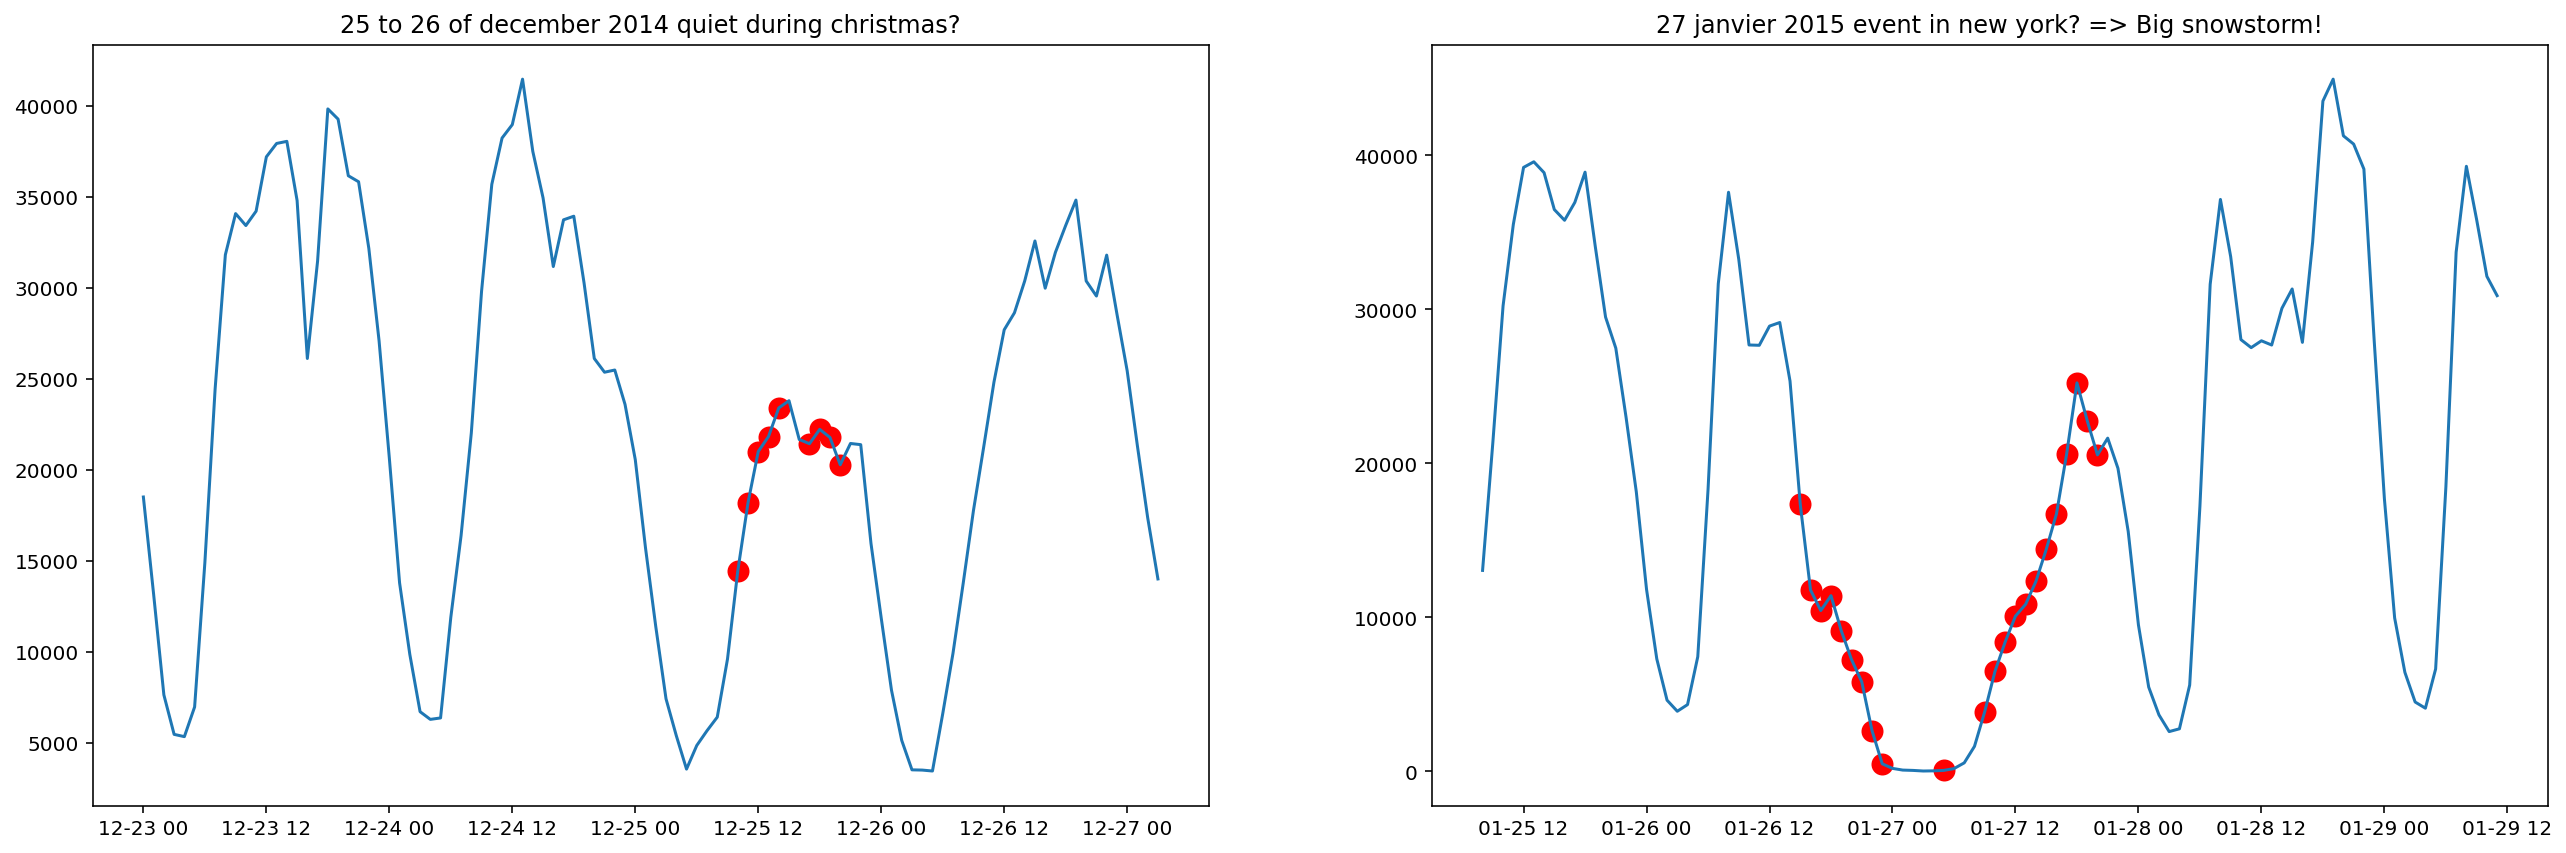

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,7))

ax1.plot(df['Date'][4200:4300],df['value'][4200:4300])
ax1.scatter(df['Date'][4200:4300],df['outliers'][4200:4300],color='red',s=100);
ax1.set_title('25 to 26 of december 2014 quiet during christmas?');

ax2.plot(df['Date'][5000:5100],df['value'][5000:5100])
ax2.scatter(df['Date'][5000:5100],df['outliers'][5000:5100],color='red',s=100);
ax2.set_title('27 janvier 2015 event in new york? => Big snowstorm!');

### Now, do you think of other ways/combinations to create new features?

## Apply same principle on 2d data:

In [16]:
data = pd.read_excel('ex8data1.xlsx', sheet_name='X', header=None,engine="openpyxl")
print(len(data))
data.head(3)

307


,0,1
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181


### Visualise data points:

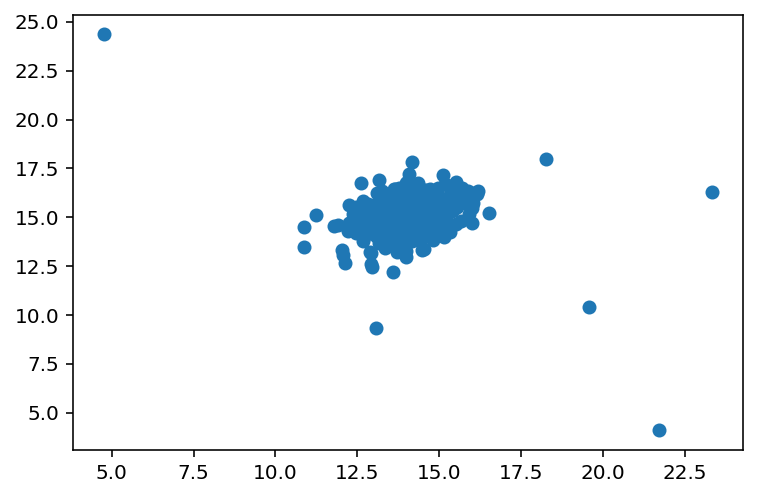

In [17]:
plt.figure()
plt.scatter(data[0], data[1])
plt.show()

### Identify outliers:

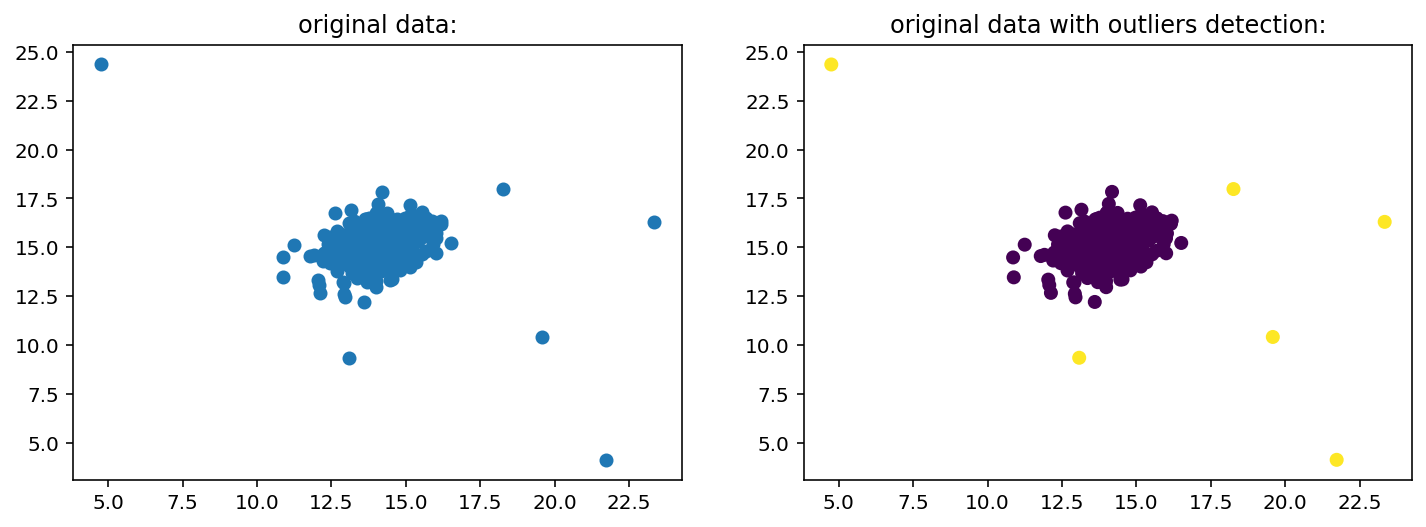

In [18]:
### Detect and exclude outliers ###
def detect_outlier(x):
    outliers=[]
    threshold_, mean_, std_ = 3, np.mean(x), np.std(x)
    
    for y in x:
        z_score= (y - mean_)/std_
        if np.abs(z_score) > threshold_:
            outliers.append(1)
        else:
            outliers.append(None)
    return outliers
###################################

data['label_0'] = detect_outlier(data[0])
data['label_1'] = detect_outlier(data[1])

data['outliers'] = None
for i in ['label_0','label_1']:
    data['outliers'] = data['outliers'].fillna(data[i])
data.drop(['label_0','label_1'], axis=1, inplace=True) 
data['outliers'] = data['outliers'].fillna(0)

## Plot:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.scatter(data[0], data[1])
ax1.set_title('original data:')

ax2.scatter(data[0], data[1],c=data['outliers'])
ax2.set_title('original data with outliers detection:')
plt.show()

graph for map:

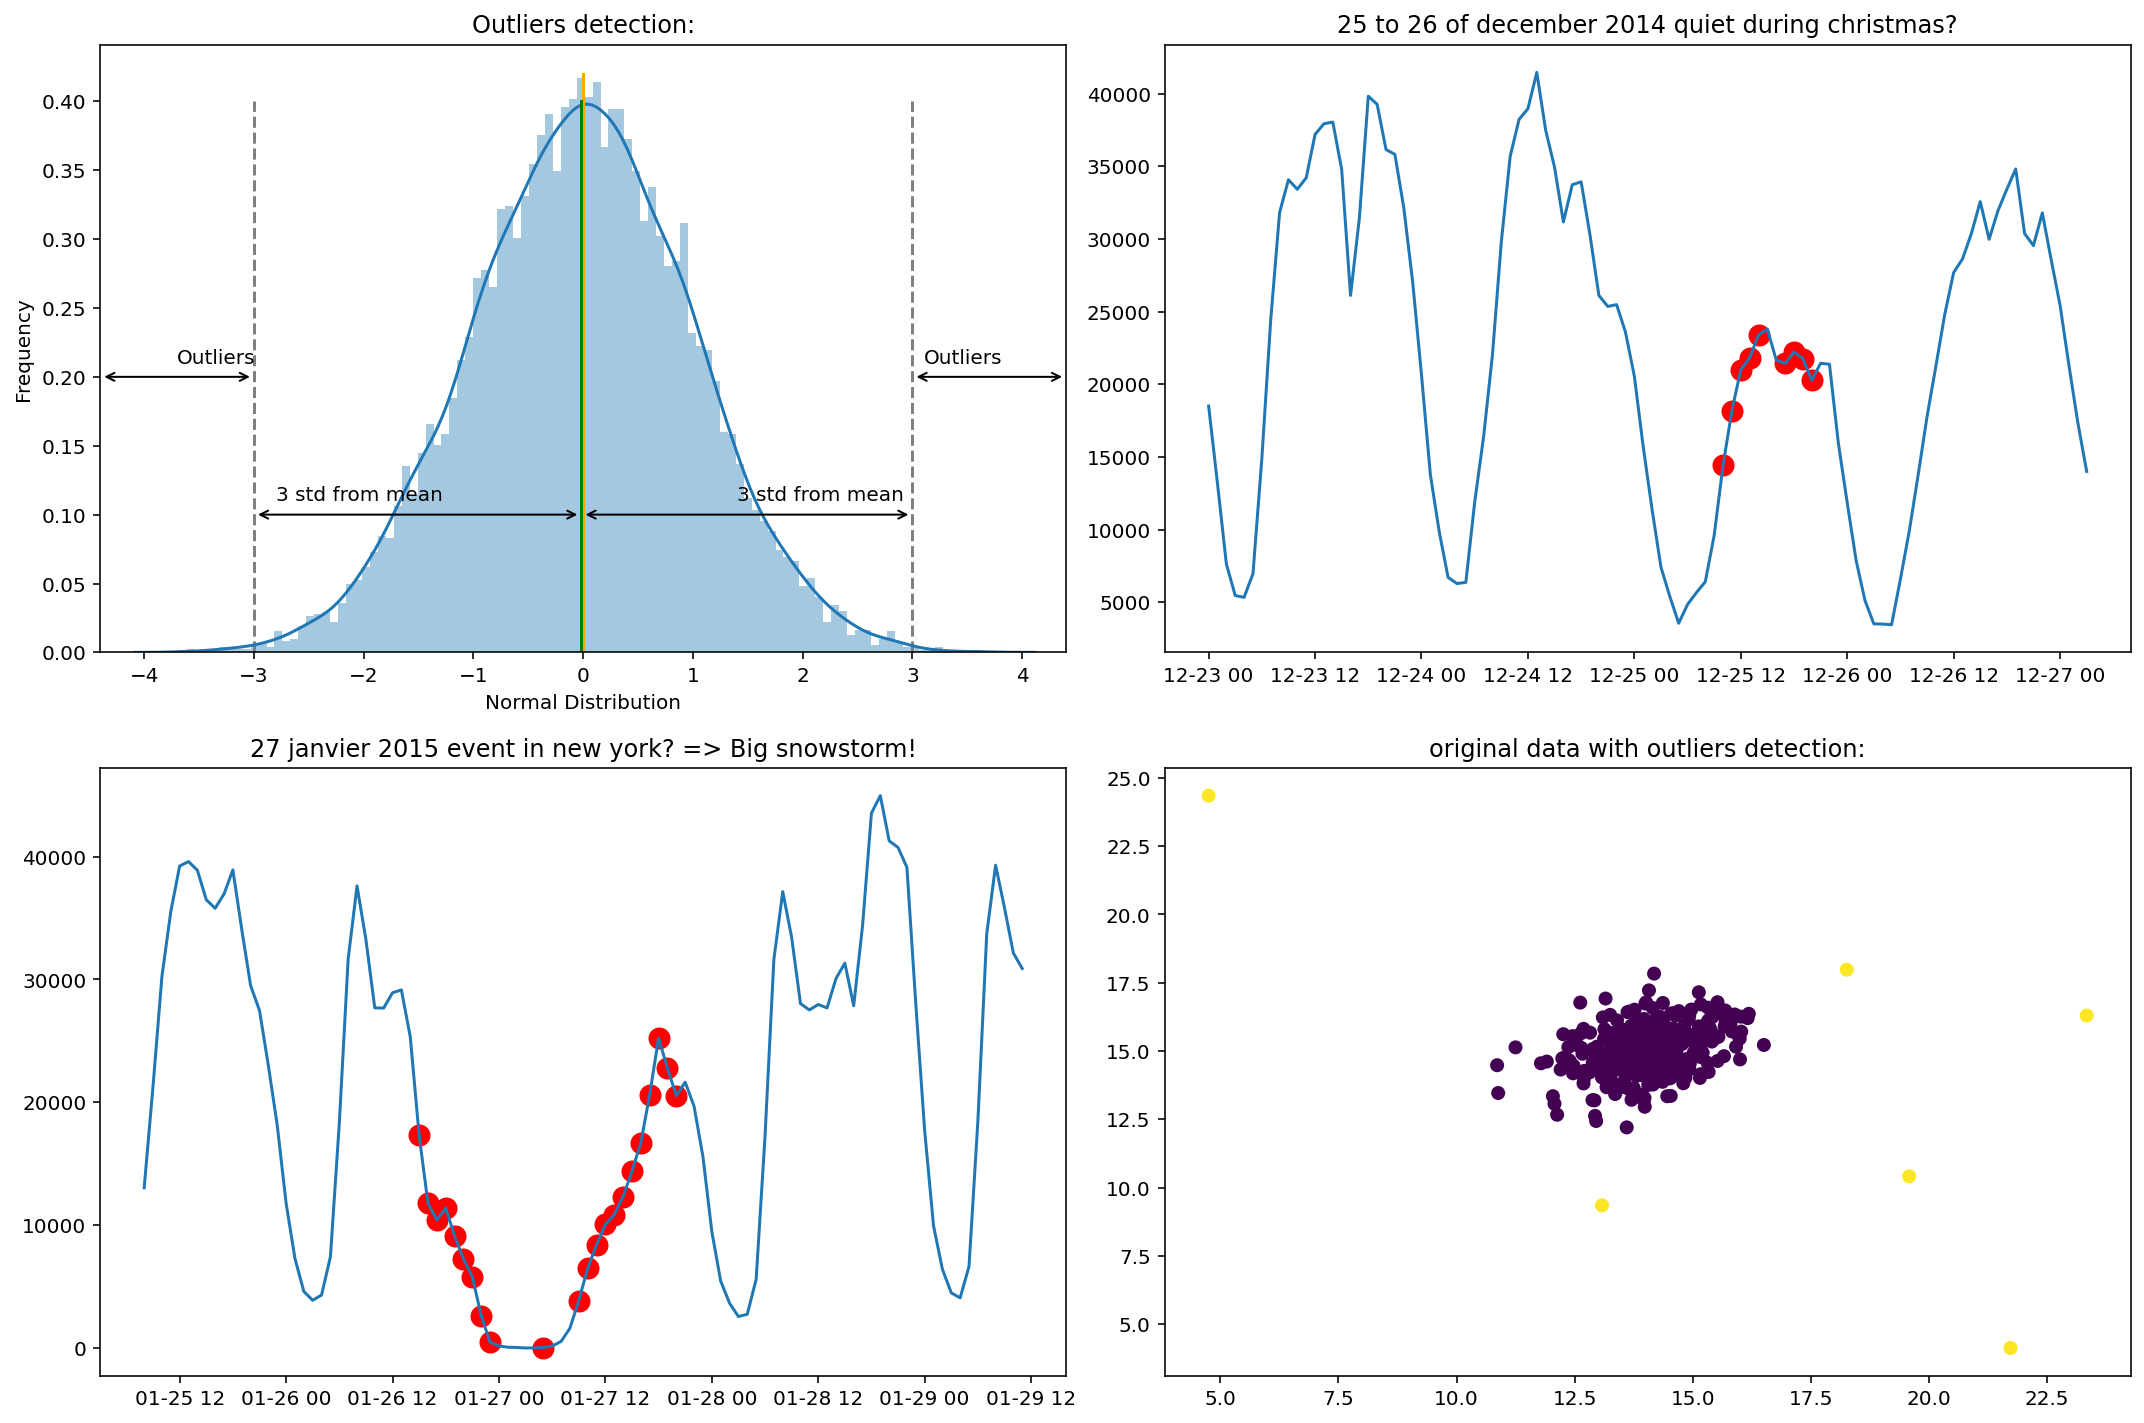

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0,0] = sns.distplot(data_normal,bins=100,kde=True,hist_kws={"linewidth": 15,'alpha':0.4},ax=axs[0,0])
axs[0,0].plot([np.median(data_normal),np.median(data_normal)],[0,0.42],color='orange')
axs[0,0].plot([np.mean(data_normal),np.mean(data_normal)],[0,0.4],color='green')

for i in [-3,3]:
    axs[0,0].vlines(i, 0, 0.4, colors='grey', linestyles='dashed', label='')
    axs[0,0].annotate(s='', xy=(np.mean(data_normal),0.1), xytext=(i,0.1),arrowprops=dict(arrowstyle='<->'))
    axs[0,0].annotate(s='', xy=(i,0.2), xytext=(i*1.4667,0.2),arrowprops=dict(arrowstyle='<->'))

axs[0,0].annotate(s='3 std from mean', xy=(np.mean(data_normal),0.11), xytext=(-2.8,0.11))
axs[0,0].annotate(s='3 std from mean', xy=(np.mean(data_normal),0.11), xytext=(1.4,0.11))
axs[0,0].annotate(s='Outliers', xy=(3.5,0.21), xytext=(3.1,0.21))
axs[0,0].annotate(s='Outliers', xy=(-3,0.21), xytext=(-3.7,0.21))
axs[0,0].set_xlim(left=-4.4,right=4.4)
axs[0,0].set(xlabel='Normal Distribution', ylabel='Frequency');
axs[0,0].set_title('Outliers detection:');

axs[1,1].scatter(data[0], data[1],c=data['outliers'])
axs[1,1].set_title('original data with outliers detection:');

axs[0,1].plot(df['Date'][4200:4300],df['value'][4200:4300])
axs[0,1].scatter(df['Date'][4200:4300],df['outliers'][4200:4300],color='red',s=100);
axs[0,1].set_title('25 to 26 of december 2014 quiet during christmas?');

axs[1,0].plot(df['Date'][5000:5100],df['value'][5000:5100])
axs[1,0].scatter(df['Date'][5000:5100],df['outliers'][5000:5100],color='red',s=100);
axs[1,0].set_title('27 janvier 2015 event in new york? => Big snowstorm!');

plt.tight_layout()
plt.savefig('Anomaly Detection.png', dpi=500,transparent=False)
plt.show()